In [2]:
# This is first and simple version of makemore.py, in which we are storing bigrams and using probability to make more
# of the same item. This is not the best way to do it, but it is a start.

In [3]:
words = open('names.txt', 'r').read().splitlines()
words = [word.lower() for word in words]

In [4]:
import torch

In [5]:
N = torch.zeros((27, 27), dtype = torch.int32)

In [6]:
chars = list('abcdefghijklmnopqrstuvwxyz')
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}  # inverse mapping

In [7]:
# count bigrams, meaning the number of times each character follows each other character
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        N[stoi[ch1], stoi[ch2]] += 1

(-0.5, 26.5, 26.5, -0.5)

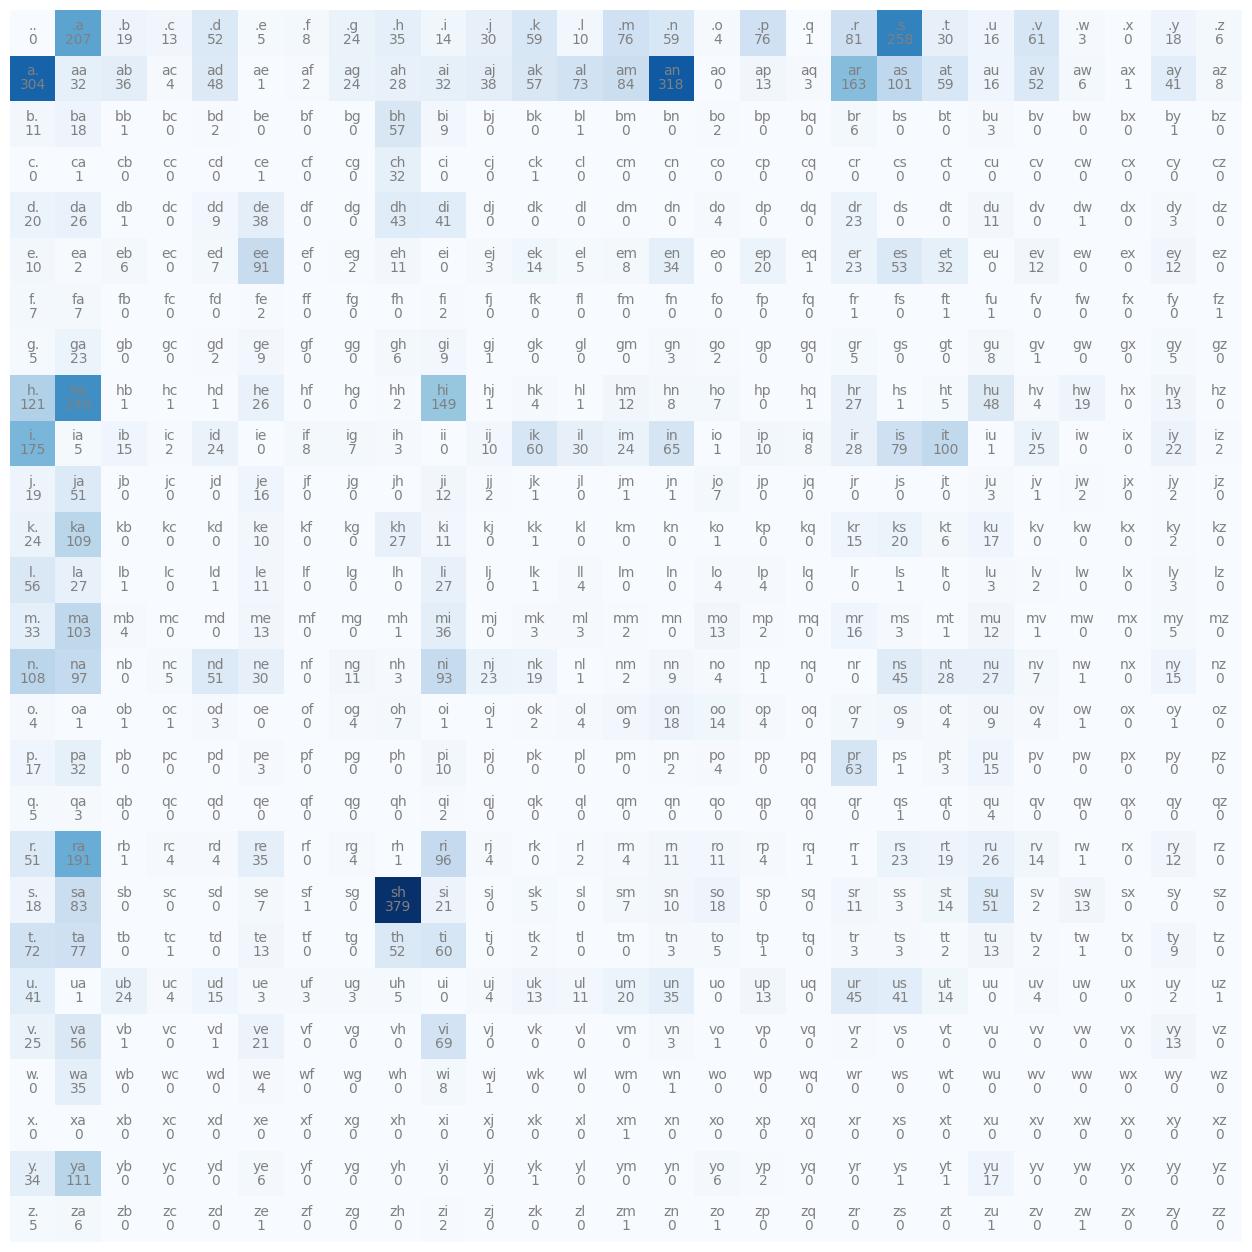

In [8]:
# plotting the matrix
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16, 16))
plt.imshow(N, cmap='Blues')
for i in range (27):
    for j in range (27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
        plt.text(j, i, N[i, j].item(), ha='center', va='top', color='gray')
plt.axis('off')


In [9]:
p = N[0].float()
p = p / p.sum()
p

tensor([0.0000, 0.1777, 0.0163, 0.0112, 0.0446, 0.0043, 0.0069, 0.0206, 0.0300,
        0.0120, 0.0258, 0.0506, 0.0086, 0.0652, 0.0506, 0.0034, 0.0652, 0.0009,
        0.0695, 0.2215, 0.0258, 0.0137, 0.0524, 0.0026, 0.0000, 0.0155, 0.0052])

In [10]:
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[ix]

'j'

In [11]:
P = (N+1).float()
P /= P.sum(1, keepdims=True)

g = torch.Generator().manual_seed(2145465)

for i in range(5):
  
  out = []
  ix = 0
  while True:
    p = P[ix]
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))



sishad.
ghi.
a.
sha.
atavisi.


In [12]:
# This is somewhat similar to loss function used in machine learning, but it is not the same.
log_likelihood = 0.0
n = 0

for w in words:
#for w in ["andrejq"]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1
    # print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

log_likelihood=tensor(-19695.9883)
nll=tensor(19695.9883)
2.250455617904663


From here we are using neural network approach of using input and their label to train the model.

In [37]:
#crete the trainig set of bigramsm (x, y)
xs, ys = [], []

for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        print(f'{ch1}{ch2} -> {ix1} {ix2}')
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

.a -> 0 1
ab -> 1 2
bh -> 2 8
hi -> 8 9
is -> 9 19
sh -> 19 8
he -> 8 5
ek -> 5 11
k. -> 11 0


In [29]:
# using one hot encoding approach

import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float()
yenc = F.one_hot(ys, num_classes=27).float()
xenc.shape

# getting weights
g = torch.Generator().manual_seed(2145465)
w = torch.randn(27, 27, generator=g)

In [33]:
logits = xenc @ w # matrix multiplication, log-count
# using softmax to normalize the counts
counts = torch.exp(logits) # equivalent to N
probs = counts / counts.sum(1, keepdims=True) # normalize

In [45]:
# --------- !!! OPTIMIZATION !!! yay --------------

In [63]:
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2145465)
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [67]:
# forward pass
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
loss = -probs[torch.arange(9), ys].log().mean()

In [66]:
# backward pass
W.grad = None
loss.backward()
W = W - 0.1 * W.grad

In [ ]:
# --------- !!! OPTIMIZATION !!! yay, but this time actually --------------

In [69]:
# create the dataset
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)

# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

number of examples:  8752


In [73]:
# gradient descent
for k in range(100):
  
  # forward pass
  xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
  logits = xenc @ W # predict log-counts
  counts = logits.exp() # counts, equivalent to N
  probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
  loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()
  print(loss.item())
  
  # backward pass
  W.grad = None # set to zero the gradient
  loss.backward()
  
  # update
  W.data += -50 * W.grad

2.255953550338745
2.255950450897217
2.2559473514556885
2.2559447288513184
2.255941867828369
2.25593900680542
2.2559361457824707
2.2559335231781006
2.255930185317993
2.255927801132202
2.255924940109253
2.2559220790863037
2.2559194564819336
2.2559165954589844
2.255913734436035
2.255910873413086
2.2559080123901367
2.2559053897857666
2.2559025287628174
2.255899667739868
2.255896806716919
2.255894184112549
2.2558913230895996
2.2558882236480713
2.255885362625122
2.255882978439331
2.255880117416382
2.2558772563934326
2.2558746337890625
2.2558717727661133
2.255869150161743
2.255866527557373
2.255863904953003
2.2558610439300537
2.2558581829071045
2.2558555603027344
2.2558529376983643
2.255849599838257
2.255847215652466
2.2558445930480957
2.2558419704437256
2.2558391094207764
2.2558364868164062
2.255833625793457
2.255830764770508
2.2558281421661377
2.2558252811431885
2.2558228969573975
2.2558200359344482
2.255817174911499
2.255814790725708
2.255812168121338
2.2558090686798096
2.2558069229125977
